In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
import dataAugmentation

In [3]:
import math
import random
import copy
import datetime

import numpy as np

from collections import deque
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

2025-04-25 18:15:15.570393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def sharpe_ratio_annualized(returns, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio of a series of returns.
    
    Parameters:
    - returns: pd.Series or np.ndarray of returns
    - risk_free_rate: float, the risk-free rate (default is 0.0)
    
    Returns:
    - Sharpe Ratio: float
    """
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

In [5]:
stocks = {
    'Dow Jones' : 'DIA',
    'S&P 500' : 'SPY',
    'NASDAQ 100' : 'QQQ',
    'FTSE 100' : 'EZU',
    'Nikkei 225' : 'EWJ',
    'Google' : 'GOOGL',
    'Apple' : 'AAPL',
    'Meta' : 'META',
    'Amazon' : 'AMZN',
    'Microsoft' : 'MSFT',
    'Nokia' : 'NOK',
    'Philips' : 'PHIA.AS',
    'Siemens' : 'SIE.DE',
    'Baidu' : 'BIDU',
    'Alibaba' : 'BABA',
    'Tencent' : '0700.HK',
    'Sony' : '6758.T',
    'JPMorgan Chase' : 'JPM',
    'HSBC' : 'HSBC',
    'CCB' : '0939.HK',
    'ExxonMobil' : 'XOM',
    'Shell' : 'SHEL',
    'PetroChina' : '0857.HK',
    'Tesla' : 'TSLA',
    'Volkswagen' : 'VOW3.DE',
    'Toyota' : '7203.T',
    'Coca Cola' : 'KO',
    'AB InBev' : 'ABI.BR',
    'Kirin' : '2503.T',
    # 'Twitter' : 'TWTR' # No accessible now
}

# Variables defining the default trading horizon
start_date = "2012-01-01"
start_validation_date = "2016-01-01"
splitting_date = '2018-01-01'
end_date = '2020-01-01'

In [6]:
# Default parameters related to the Experience Replay mechanism
capacity = 100000
batchSize = 32
experiencesRequired = 1000

class ReplayMemory:
    """
    GOAL: Implementing the replay memory required for the Experience Replay
          mechanism of the DQN Reinforcement Learning algorithm.
    
    VARIABLES:  - memory: Data structure storing the experiences.
                                
    METHODS:    - __init__: Initialization of the memory data structure.
                - push: Insert a new experience into the replay memory.
                - sample: Sample a batch of experiences from the replay memory.
                - __len__: Return the length of the replay memory.
                - reset: Reset the replay memory.
    """

    def __init__(self, capacity=capacity):
        """
        GOAL: Initializating the replay memory data structure.
        
        INPUTS: - capacity: Capacity of the data structure, specifying the
                            maximum number of experiences to be stored
                            simultaneously.
        
        OUTPUTS: /
        """

        self.memory = deque(maxlen=capacity)
    

    def push(self, state, action, reward, nextState, done):
        """
        GOAL: Insert a new experience into the replay memory. An experience
              is composed of a state, an action, a reward, a next state and
              a termination signal.
        
        INPUTS: - state: RL state of the experience to be stored.
                - action: RL action of the experience to be stored.
                - reward: RL reward of the experience to be stored.
                - nextState: RL next state of the experience to be stored.
                - done: RL termination signal of the experience to be stored.
        
        OUTPUTS: /
        """

        self.memory.append((state, action, reward, nextState, done))


    def sample(self, batchSize):
        """
        GOAL: Sample a batch of experiences from the replay memory.
        
        INPUTS: - batchSize: Size of the batch to sample.
        
        OUTPUTS: - state: RL states of the experience batch sampled.
                 - action: RL actions of the experience batch sampled.
                 - reward: RL rewards of the experience batch sampled.
                 - nextState: RL next states of the experience batch sampled.
                 - done: RL termination signals of the experience batch sampled.
        """

        state, action, reward, nextState, done = zip(*random.sample(self.memory, batchSize))
        return state, action, reward, nextState, done


    def __len__(self):
        """
        GOAL: Return the capicity of the replay memory, which is the maximum number of
              experiences which can be simultaneously stored in the replay memory.
        
        INPUTS: /
        
        OUTPUTS: - length: Capacity of the replay memory.
        """

        return len(self.memory)


    def reset(self):
        """
        GOAL: Reset (empty) the replay memory.
        
        INPUTS: /
        
        OUTPUTS: /
        """

        self.memory = deque(maxlen=capacity)

In [7]:
# Default parameters related to the DQN algorithm
gamma = 0.4
learningRate = 0.0001
targetNetworkUpdate = 1000
learningUpdatePeriod = 1

# Default parameters related to the Deep Neural Network
numberOfNeurons = 512
dropout = 0.2

# Default parameter related to the L2 Regularization 
L2Factor = 0.000001

def DQN(numberOfInputs, numberOfOutputs, numberOfNeurons=numberOfNeurons, dropout=dropout):
    """
    GOAL: Implement a Deep Q-Network (DQN) using a functional approach.
    
    INPUTS:
    - numberOfInputs: Number of input features.
    - numberOfOutputs: Number of possible actions (Q-values output).
    - numberOfNeurons: Number of neurons per hidden layer (default: 128).
    - dropout: Dropout probability for regularization (default: 0.1).
    
    OUTPUTS:
    - A PyTorch Sequential model representing the Deep Q-Network.
    """
    model = nn.Sequential(
        nn.Linear(numberOfInputs, numberOfNeurons, bias=False),
        nn.BatchNorm1d(numberOfNeurons),
        nn.LeakyReLU(),
        nn.Dropout(dropout),

        nn.Linear(numberOfNeurons, numberOfNeurons, bias=False),
        nn.BatchNorm1d(numberOfNeurons),
        nn.LeakyReLU(),
        nn.Dropout(dropout),

        nn.Linear(numberOfNeurons, numberOfNeurons, bias=False),
        nn.BatchNorm1d(numberOfNeurons),
        nn.LeakyReLU(),
        nn.Dropout(dropout),

        nn.Linear(numberOfNeurons, numberOfNeurons, bias=False),
        nn.BatchNorm1d(numberOfNeurons),
        nn.LeakyReLU(),
        nn.Dropout(dropout),
        
        nn.Linear(numberOfNeurons, numberOfOutputs, bias=False)
    )
    
    # Initialize weights using Xavier initialization
    for layer in model:
        if isinstance(layer, nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)
    
    return model


In [8]:
money = 100000

def reset_data(data):
    """
    GOAL: Reset the trading environment to its initial state.
    
    INPUTS: - data: DataFrame containing the trading data.
    
    OUTPUTS: - data: DataFrame with the reset values.
    """

    # Reset the trading environment
    data['Position'] = 0
    data['Action'] = 0
    data['Holdings'] = 0.
    data['Cash'] = float(money)
    data['Money'] = data['Holdings'] + data['Cash']
    data['Returns'] = 0.

    return data

In [9]:
def getNormalizationCoefficients(data):
    """
    GOAL: Retrieve the coefficients required for the normalization
            of input data.
    
    INPUTS: - tradingEnv: RL trading environement to process.
    
    OUTPUTS: - coefficients: Normalization coefficients.
    """

    # Retrieve the available trading data
#     tradingData = tradingEnv
    closePrices = data['Close'].tolist()
    lowPrices = data['Low'].tolist()
    highPrices = data['High'].tolist()
    volumes = data['Volume'].tolist()

    # Retrieve the coefficients required for the normalization
    coefficients = []
    margin = 1
    # 1. Close price => returns (absolute) => maximum value (absolute)
    returns = [abs((closePrices[i]-closePrices[i-1])/closePrices[i-1]) for i in range(1, len(closePrices))]
    coeffs = (0, np.max(returns)*margin)
    coefficients.append(coeffs)
    # 2. Low/High prices => Delta prices => maximum value
    deltaPrice = [abs(highPrices[i]-lowPrices[i]) for i in range(len(lowPrices))]
    coeffs = (0, np.max(deltaPrice)*margin)
    coefficients.append(coeffs)
    # 3. Close/Low/High prices => Close price position => no normalization required
    coeffs = (0, 1)
    coefficients.append(coeffs)
    # 4. Volumes => minimum and maximum values
    coeffs = (np.min(volumes)/margin, np.max(volumes)*margin)
    coefficients.append(coeffs)
    
    return coefficients

In [10]:
def initState(data, stateLength):
    """
    GOAL: Setting an arbitrary starting point regarding the trading activity.
            This technique is used for better generalization of the RL agent.
    
    INPUTS: - startingPoint: Optional starting point (iteration) of the trading activity.
    
    OUTPUTS: /
    """

    # Set the RL variables common to every OpenAI gym environments
    state = [data['Close'][0: stateLength].tolist(),
                    data['Low'][0: stateLength].tolist(),
                    data['High'][0: stateLength].tolist(),
                    data['Volume'][0: stateLength].tolist(),
                    [0]]
    return state

In [11]:
def processState(state, coefficients):
    """
    GOAL: Process the RL state returned by the environment
            (appropriate format and normalization).
    
    INPUTS: - state: RL state returned by the environment.
    
    OUTPUTS: - state: Processed RL state.
    """

    # Normalization of the RL state
    closePrices = [state[0][i] for i in range(len(state[0]))]
    lowPrices = [state[1][i] for i in range(len(state[1]))]
    highPrices = [state[2][i] for i in range(len(state[2]))]
    volumes = [state[3][i] for i in range(len(state[3]))]

    # 1. Close price => returns => MinMax normalization
    returns = [(closePrices[i]-closePrices[i-1])/closePrices[i-1] for i in range(1, len(closePrices))]
    if coefficients[0][0] != coefficients[0][1]:
        state[0] = [((x - coefficients[0][0])/(coefficients[0][1] - coefficients[0][0])) for x in returns]
    else:
        state[0] = [0 for x in returns]
    # 2. Low/High prices => Delta prices => MinMax normalization
    deltaPrice = [abs(highPrices[i]-lowPrices[i]) for i in range(1, len(lowPrices))]
    if coefficients[1][0] != coefficients[1][1]:
        state[1] = [((x - coefficients[1][0])/(coefficients[1][1] - coefficients[1][0])) for x in deltaPrice]
    else:
        state[1] = [0 for x in deltaPrice]
    # 3. Close/Low/High prices => Close price position => No normalization required
    closePricePosition = []
    for i in range(1, len(closePrices)):
        deltaPrice = abs(highPrices[i]-lowPrices[i])
        if deltaPrice != 0:
            item = abs(closePrices[i]-lowPrices[i])/deltaPrice
        else:
            item = 0.5
        closePricePosition.append(item)
    if coefficients[2][0] != coefficients[2][1]:
        state[2] = [((x - coefficients[2][0])/(coefficients[2][1] - coefficients[2][0])) for x in closePricePosition]
    else:
        state[2] = [0.5 for x in closePricePosition]
    # 4. Volumes => MinMax normalization
    volumes = [volumes[i] for i in range(1, len(volumes))]
    if coefficients[3][0] != coefficients[3][1]:
        state[3] = [((x - coefficients[3][0])/(coefficients[3][1] - coefficients[3][0])) for x in volumes]
    else:
        state[3] = [0 for x in volumes]
    
    # Process the state structure to obtain the appropriate format
    state = [item for sublist in state for item in sublist]

    return state

In [12]:
def chooseAction(state, mainNetwork):
        """
        GOAL: Choose a valid RL action from the action space according to the
              RL policy as well as the current RL state observed.
        
        INPUTS: - state: RL state returned by the environment.
        
        OUTPUTS: - action: RL action chosen from the action space.
                 - Q: State-action value function associated.
                 - QValues: Array of all the Qvalues outputted by the
                            Deep Neural Network.
        """

        # Choose the best action based on the RL policy
        with torch.no_grad():
            tensorState = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            QValues = mainNetwork(tensorState).squeeze(0)
            Q, action = QValues.max(0)
            action = action.item()
            Q = Q.item()
            QValues = QValues.cpu().numpy()
            return action, Q, QValues
        
# Default parameters related to the Epsilon-Greedy exploration technique
epsilonStart = 1.0
epsilonEnd = 0.01
epsilonDecay = 10000

# Default parameters regarding the sticky actions RL generalization technique
alpha = 0.1

# Variables defining the default observation and state spaces
stateLength = 30
observationSpace = 1 + (stateLength-1)*4
actionSpace = 2

def chooseActionEpsilonGreedy(state, previousAction, mainNetwork, iterations):
    """
    GOAL: Choose a valid RL action from the action space according to the
            RL policy as well as the current RL state observed, following the 
            Epsilon Greedy exploration mechanism.

    INPUTS: - state: RL state returned by the environment.
            - previousAction: Previous RL action executed by the agent.

    OUTPUTS: - action: RL action chosen from the action space.
                - Q: State-action value function associated.
                - QValues: Array of all the Qvalues outputted by the
                        Deep Neural Network.
    """
    epsilonValue = lambda iteration: epsilonEnd + (epsilonStart - epsilonEnd) * math.exp(-1 * iteration / epsilonDecay)
    # EXPLOITATION -> RL policy
    if(random.random() > epsilonValue(iterations)):
        # Sticky action (RL generalization mechanism)
        if(random.random() > alpha):
            action, Q, QValues = chooseAction(state, mainNetwork)
        else:
            action = previousAction
            Q = 0
            QValues = [0, 0]

    # EXPLORATION -> Random
    else:
        action = random.randrange(actionSpace)
        Q = 0
        QValues = [0, 0]

    # Increment the iterations counter (for Epsilon Greedy)
    iterations += 1

    return action, Q, QValues, iterations

In [13]:
def computeLowerBound(cash, numberOfShares, price, transactionCosts, epsilon):
    """
    GOAL: Compute the lower bound of the complete RL action space, 
            i.e. the minimum number of share to trade.
    
    INPUTS: - cash: Value of the cash owned by the agent.
            - numberOfShares: Number of shares owned by the agent.
            - price: Last price observed.
    
    OUTPUTS: - lowerBound: Lower bound of the RL action space.
    """

    # Computation of the RL action lower bound
    deltaValues = - cash - numberOfShares * price * (1 + epsilon) * (1 + transactionCosts)
    if deltaValues < 0:
        lowerBound = deltaValues / (price * (2 * transactionCosts + (epsilon * (1 + transactionCosts))))
    else:
        lowerBound = deltaValues / (price * epsilon * (1 + transactionCosts))
    return lowerBound

def step(action, data, t, numberOfShares, transactionCosts, stateLength, epsilon, done):
    """
    GOAL: Transition to the next trading time step based on the
            trading position decision made (either long or short).
    
    INPUTS: - action: Trading decision (1 = long, 0 = short).    
    
    OUTPUTS: - state: RL state to be returned to the RL agent.
                - reward: RL reward to be returned to the RL agent.
                - done: RL episode termination signal (boolean).
                - info: Additional information returned to the RL agent.
    """

    # Stting of some local variables
    # t = t
    # numberOfShares = numberOfShares
    customReward = False

    # CASE 1: LONG POSITION
    if(action == 1):
        data['Position'][t] = 1
        # Case a: Long -> Long
        if(data['Position'][t - 1] == 1):
            data['Cash'][t] = data['Cash'][t - 1]
            data['Holdings'][t] = numberOfShares * data['Close'][t]
        # Case b: No position -> Long
        elif(data['Position'][t - 1] == 0):
            numberOfShares = math.floor(data['Cash'][t - 1]/(data['Close'][t] * (1 + transactionCosts)))
            data['Cash'][t] = data['Cash'][t - 1] - numberOfShares * data['Close'][t] * (1 + transactionCosts)
            data['Holdings'][t] = numberOfShares * data['Close'][t]
            data['Action'][t] = 1
        # Case c: Short -> Long
        else:
            data['Cash'][t] = data['Cash'][t - 1] - numberOfShares * data['Close'][t] * (1 + transactionCosts)
            numberOfShares = math.floor(data['Cash'][t]/(data['Close'][t] * (1 + transactionCosts)))
            data['Cash'][t] = data['Cash'][t] - numberOfShares * data['Close'][t] * (1 + transactionCosts)
            data['Holdings'][t] = numberOfShares * data['Close'][t]
            data['Action'][t] = 1

    # CASE 2: SHORT POSITION
    elif(action == 0):
        data['Position'][t] = -1
        # Case a: Short -> Short
        if(data['Position'][t - 1] == -1):
            lowerBound = computeLowerBound(data['Cash'][t - 1], -numberOfShares, data['Close'][t-1], transactionCosts, epsilon)
            if lowerBound <= 0:
                data['Cash'][t] = data['Cash'][t - 1]
                data['Holdings'][t] =  - numberOfShares * data['Close'][t]
            else:
                numberOfSharesToBuy = min(math.floor(lowerBound), numberOfShares)
                numberOfShares -= numberOfSharesToBuy
                data['Cash'][t] = data['Cash'][t - 1] - numberOfSharesToBuy * data['Close'][t] * (1 + transactionCosts)
                data['Holdings'][t] =  - numberOfShares * data['Close'][t]
                customReward = True
        # Case b: No position -> Short
        elif(data['Position'][t - 1] == 0):
            numberOfShares = math.floor(data['Cash'][t - 1]/(data['Close'][t] * (1 + transactionCosts)))
            data['Cash'][t] = data['Cash'][t - 1] + numberOfShares * data['Close'][t] * (1 - transactionCosts)
            data['Holdings'][t] = - numberOfShares * data['Close'][t]
            data['Action'][t] = -1
        # Case c: Long -> Short
        else:
            data['Cash'][t] = data['Cash'][t - 1] + numberOfShares * data['Close'][t] * (1 - transactionCosts)
            numberOfShares = math.floor(data['Cash'][t]/(data['Close'][t] * (1 + transactionCosts)))
            data['Cash'][t] = data['Cash'][t] + numberOfShares * data['Close'][t] * (1 - transactionCosts)
            data['Holdings'][t] = - numberOfShares * data['Close'][t]
            data['Action'][t] = -1

    # CASE 3: PROHIBITED ACTION
    else:
        raise SystemExit("Prohibited action! Action should be either 1 (long) or 0 (short).")

    # Update the total amount of money owned by the agent, as well as the return generated
    data['Money'][t] = data['Holdings'][t] + data['Cash'][t]
    data['Returns'][t] = (data['Money'][t] - data['Money'][t-1])/data['Money'][t-1]

    # Set the RL reward returned to the trading agent
    if not customReward:
        reward = data['Returns'][t]
    else:
        reward = (data['Close'][t-1] - data['Close'][t])/data['Close'][t-1]

    # numberOfSharesMain = numberOfShares
    # Transition to the next trading time step
    t_state = t + 1
    state = [data['Close'][t_state - stateLength : t_state].tolist(),
                    data['Low'][t_state - stateLength : t_state].tolist(),
                    data['High'][t_state - stateLength : t_state].tolist(),
                    data['Volume'][t_state - stateLength : t_state].tolist(),
                    [data['Position'][t_state - 1]]]
    
    if(t_state == data.shape[0]):
        done = 1  

    # Same reasoning with the other action (exploration trick)
    otherAction = int(not bool(action))
    customReward = False
    if(otherAction == 1):
        otherPosition = 1
        if(data['Position'][t - 1] == 1):
            otherCash = data['Cash'][t - 1]
            otherHoldings = numberOfShares * data['Close'][t]
        elif(data['Position'][t - 1] == 0):
            numberOfShares = math.floor(data['Cash'][t - 1]/(data['Close'][t] * (1 + transactionCosts)))
            otherCash = data['Cash'][t - 1] - numberOfShares * data['Close'][t] * (1 + transactionCosts)
            otherHoldings = numberOfShares * data['Close'][t]
        else:
            otherCash = data['Cash'][t - 1] - numberOfShares * data['Close'][t] * (1 + transactionCosts)
            numberOfShares = math.floor(otherCash/(data['Close'][t] * (1 + transactionCosts)))
            otherCash = otherCash - numberOfShares * data['Close'][t] * (1 + transactionCosts)
            otherHoldings = numberOfShares * data['Close'][t]
    else:
        otherPosition = -1
        if(data['Position'][t - 1] == -1):
            lowerBound = computeLowerBound(data['Cash'][t - 1], -numberOfShares, data['Close'][t-1], transactionCosts, epsilon)
            if lowerBound <= 0:
                otherCash = data['Cash'][t - 1]
                otherHoldings =  - numberOfShares * data['Close'][t]
            else:
                numberOfSharesToBuy = min(math.floor(lowerBound), numberOfShares)
                numberOfShares -= numberOfSharesToBuy
                otherCash = data['Cash'][t - 1] - numberOfSharesToBuy * data['Close'][t] * (1 + transactionCosts)
                otherHoldings =  - numberOfShares * data['Close'][t]
                customReward = True
        elif(data['Position'][t - 1] == 0):
            numberOfShares = math.floor(data['Cash'][t - 1]/(data['Close'][t] * (1 + transactionCosts)))
            otherCash = data['Cash'][t - 1] + numberOfShares * data['Close'][t] * (1 - transactionCosts)
            otherHoldings = - numberOfShares * data['Close'][t]
        else:
            otherCash = data['Cash'][t - 1] + numberOfShares * data['Close'][t] * (1 - transactionCosts)
            numberOfShares = math.floor(otherCash/(data['Close'][t] * (1 + transactionCosts)))
            otherCash = otherCash + numberOfShares * data['Close'][t] * (1 - transactionCosts)
            otherHoldings = - numberOfShares * data['Close'][t]
    otherMoney = otherHoldings + otherCash
    if not customReward:
        otherReward = (otherMoney - data['Money'][t-1])/data['Money'][t-1]
    else:
        otherReward = (data['Close'][t-1] - data['Close'][t])/data['Close'][t-1]
    otherState = [data['Close'][t_state - stateLength : t_state].tolist(),
                    data['Low'][t_state - stateLength : t_state].tolist(),
                    data['High'][t_state - stateLength : t_state].tolist(),
                    data['Volume'][t_state - stateLength : t_state].tolist(),
                    [otherPosition]]
    info = {'State' : otherState, 'Reward' : otherReward, 'Done' : done}

    # Return the trading environment feedback to the RL trading agent
    return state, reward, info, numberOfShares, done

In [14]:
rewardClipping = 1

def processReward(reward):
    """
    GOAL: Process the RL reward returned by the environment by clipping
            its value. Such technique has been shown to improve the stability
            the DQN algorithm.
    
    INPUTS: - reward: RL reward returned by the environment.
    
    OUTPUTS: - reward: Process RL reward.
    """

    return np.clip(reward, -rewardClipping, rewardClipping)

In [15]:
targetNetworkUpdate = 1000

def updateTargetNetwork(iterations, mainNetwork, targetNetwork):
    """
    GOAL: Update the target network weights with the main network weights
            every targetNetworkUpdate iterations.
    
    INPUTS: - iterations: Number of iterations executed.
            - mainNetwork: Main DQN network.
            - targetNetwork: Target DQN network.
    
    OUTPUTS: /
    """

    if(iterations % targetNetworkUpdate == 0):
        targetNetwork.load_state_dict(mainNetwork.state_dict())

In [16]:
gradientClipping = 1
batchSize = 32  # Size of the batch used for the training of the DQN
# Default parameters related to the DQN algorithm
gamma = 0.4
learningRate = 0.0001
targetNetworkUpdate = 1000
learningUpdatePeriod = 1

GPUNumber = 0
device = torch.device('cuda:'+str(GPUNumber) if torch.cuda.is_available() else 'cpu')

def learning(iterations, done, replayMemory, mainNetwork, targetNetwork, optimizer, batchSize=batchSize):
    """
    GOAL: Sample a batch of past experiences and learn from it
            by updating the Reinforcement Learning policy.
    
    INPUTS: batchSize: Size of the batch to sample from the replay memory.
    
    OUTPUTS: /
    """
    
    # Check that the replay memory is filled enough
    if (len(replayMemory) >= batchSize):
        # Set the Deep Neural Network in training mode
        mainNetwork.train()

        # Sample a batch of experiences from the replay memory
        state, action, reward, nextState, done = replayMemory.sample(batchSize)
        # print(done)

        # Initialization of Pytorch tensors for the RL experience elements
        state = torch.tensor(np.array(state), dtype=torch.float, device=device)
        action = torch.tensor(action, dtype=torch.long, device=device)
        reward = torch.tensor(reward, dtype=torch.float, device=device)
        nextState = torch.tensor(nextState, dtype=torch.float, device=device)
        done = torch.tensor(done, dtype=torch.float, device=device)

        # print(done)
        # Compute the current Q values returned by the policy network
        currentQValues = mainNetwork(state).gather(1, action.unsqueeze(1)).squeeze(1)

        # Compute the next Q values returned by the target network
        with torch.no_grad():
            nextActions = torch.max(mainNetwork(nextState), 1)[1]
            nextQValues = targetNetwork(nextState).gather(1, nextActions.unsqueeze(1)).squeeze(1)
            expectedQValues = reward + gamma * nextQValues * (1 - done)

        # Compute the Huber loss
        loss = F.smooth_l1_loss(currentQValues, expectedQValues)

        # Computation of the gradients
        optimizer.zero_grad()
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(mainNetwork.parameters(), gradientClipping)

        # Perform the Deep Neural Network optimization
        optimizer.step()

        # If required, update the target deep neural network (update frequency)
        updateTargetNetwork(iterations, mainNetwork, targetNetwork)

        # Set back the Deep Neural Network in evaluation mode
        mainNetwork.eval()
        


In [17]:
def setStartingPoint(startingPoint, data, stateLength):
    """
    GOAL: Setting an arbitrary starting point regarding the trading activity.
            This technique is used for better generalization of the RL agent.
    
    INPUTS: - startingPoint: Optional starting point (iteration) of the trading activity.
    
    OUTPUTS: /
    """

    # Setting a custom starting point
    t = np.clip(startingPoint, stateLength, len(data.index))

    # Set the RL variables common to every OpenAI gym environments
    state = [data['Close'][t - stateLength : t].tolist(),
                    data['Low'][t - stateLength : t].tolist(),
                    data['High'][t - stateLength : t].tolist(),
                    data['Volume'][t - stateLength : t].tolist(),
                    [data['Position'][t - 1]]]
    if(t == data.shape[0]):
        done = 1
    else:
        done = 0
    return state, t, done

In [68]:
# TQDN
import warnings
from pandas.errors import SettingWithCopyWarning  # <-- Add this line

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

random.seed(0)

stockName, startingDate, splittingDate, endingDate = 'Apple', '2012-01-01', '2018-01-01', '2020-01-01'
dataTraining = pd.read_csv('data/AAPL_'+startingDate+'_'+splitting_date+'.csv').set_index('Date')
dataTrainingAugmented = dataAugmentation.generate(dataTraining.copy())[0]
dataTest = pd.read_csv('data/AAPL_'+splitting_date+'_'+endingDate+'.csv').set_index('Date')
dataTraining = reset_data(dataTraining)

# 1. Initialize - Set the two Deep Neural Networks of the DQN algorithm (policy/main and target)
replayMemory = ReplayMemory(capacity=capacity)  # Experience replay memory
main_network = DQN(observationSpace, actionSpace, numberOfNeurons, dropout).to(device)   # Main DQN (θ), with Xavier init
target_network = DQN(observationSpace, actionSpace, numberOfNeurons, dropout).to(device) # Target DQN (θ⁻)
target_network.load_state_dict(main_network.state_dict())  # Initialize target network with main network
main_network.eval()
target_network.eval()

# Set the Deep Learning optimizer
optimizer = optim.Adam(main_network.parameters(), lr=learningRate, weight_decay=L2Factor)  # Adam optimizer

# Initialization of the iterations counter
iterations = 0

# 2. Training Loop
print("Training progression (hardware selected => " + str(device) + "):")
for episode in tqdm(range(50)):
    
    # Set the initial RL variables
    numberOfShares = 0
    transactionCosts = 0.1/100
    previousAction = 0
    done = 0
    t = stateLength
    epsilon = 0.1
    
    coefficients = getNormalizationCoefficients(dataTrainingAugmented)
    dataTrainingAugmented = reset_data(dataTrainingAugmented)
    initial_state = initState(dataTrainingAugmented, stateLength)
    startingPoint = random.randrange(len(dataTrainingAugmented.index))
    initial_state, t, done = setStartingPoint(startingPoint, dataTrainingAugmented, stateLength)
    state = processState(initial_state, coefficients)
    
    while done == 0:

        # 3. Epsilon-Greedy Policy
        action, _, _, iterations  = chooseActionEpsilonGreedy(state, previousAction, main_network, iterations)  # random action
        # epsilon = epsilonValue(iterations)  # Epsilon value
        # Interact with the environment with the chosen action
        nextState, reward, info, numberOfShares, done = step(action, dataTrainingAugmented, t, numberOfShares, transactionCosts, stateLength, epsilon, done)
        
        # Process the RL variables retrieved and insert this new experience into the Experience Replay memory
        reward = processReward(reward)
        nextState = processState(nextState, coefficients)
        replayMemory.push(state, action, reward, nextState, done)

        # Trick for better exploration
        otherAction = int(not bool(action))
        otherReward = processReward(info['Reward'])
        otherNextState = processState(info['State'], coefficients)
        otherDone = info['Done']
        replayMemory.push(state, otherAction, otherReward, otherNextState, otherDone)

        # Execute the DQN learning procedure - Update the policy/main network and the target network
        learning(iterations, done, replayMemory, main_network, target_network, optimizer)  # Learning step
        
        # Update the RL state
        state = nextState
        previousAction = action
        t += 1


Training progression (hardware selected => cpu):


100%|██████████| 50/50 [12:38<00:00, 15.16s/it]


In [69]:
def testing(dataTraining, dataTesting, main_network):
    """
    GOAL: Test the RL agent trading policy on a new trading environment
            in order to assess the trading strategy performance.
    
    INPUTS: - trainingEnv: Training RL environment (known).
            - testingEnv: Unknown trading RL environment.
            - rendering: Enable the trading environment rendering.
            - showPerformance: Enable the printing of a table summarizing
                                the trading strategy performance.
    
    OUTPUTS: - testingEnv: Trading environment backtested.
    """

    # Initialization of some RL variables
    dataTestingSmoothed = dataAugmentation.lowPassFilter(dataTesting.copy())
    dataTraining = dataAugmentation.lowPassFilter(dataTraining.copy())
    dataTestingSmoothed = reset_data(dataTestingSmoothed)
    
    coefficients = getNormalizationCoefficients(dataTraining)
    initial_state = initState(dataTestingSmoothed, stateLength)
    state = processState(initial_state, coefficients)
    dataTesting = reset_data(dataTesting)
    
    QValues0 = []
    QValues1 = []
    done = 0
    numberOfShares = 0
    transactionCosts = 0.1/100
    t = stateLength
    
    # Interact with the environment until the episode termination
    while done == 0:

        # Choose an action according to the RL policy and the current RL state
        action, _, QValues = chooseAction(state, main_network)
            
        # Interact with the environment with the chosen action
        nextState, _, _, numberOfShares, done = step(action, dataTestingSmoothed, t, numberOfShares, transactionCosts, stateLength, epsilon, done)
        _, _, _, _, _ = step(action, dataTesting, t, numberOfShares, transactionCosts, stateLength, epsilon, done)
        # Update the new state
        state = processState(nextState, coefficients)

        # Storing of the Q values
        QValues0.append(QValues[0])
        QValues1.append(QValues[1])
        
        t += 1
        
    return dataTesting, QValues0, QValues1

In [70]:
def render(data):
    fig = plt.figure(figsize=(15, 11))
    ax1 = fig.add_subplot(211, ylabel='Price', xlabel='Date')
    ax2 = fig.add_subplot(212, ylabel='Capital', xlabel='Date')
    
    data['Close'].plot(ax=ax1, color='blue', lw=2.)
    ax1.plot(data[data['Action'] == 1].index, data['Close'][data['Action'] == 1], '^', markersize=5, color='g')
    ax1.plot(data[data['Action'] == -1].index, data['Close'][data['Action'] == -1], 'v', markersize=5, color='r')
    
    data['Money'].plot(ax=ax2, color='blue', lw=2.)
    ax2.plot(data[data['Action'] == 1].index, data['Money'][data['Action'] == 1], '^', markersize=5, color='g')
    ax2.plot(data[data['Action'] == -1].index, data['Money'][data['Action'] == -1], 'v', markersize=5, color='r')
    
    ax1.legend(['Price', 'Long', 'Short'], loc='best')
    ax2.legend(['Capital', 'Long', 'Short'], loc='best')

In [99]:
TrainingData, QValues0, QValues1 = testing(dataTraining, dataTraining, main_network)
TrainingData.index = pd.to_datetime(TrainingData.index)

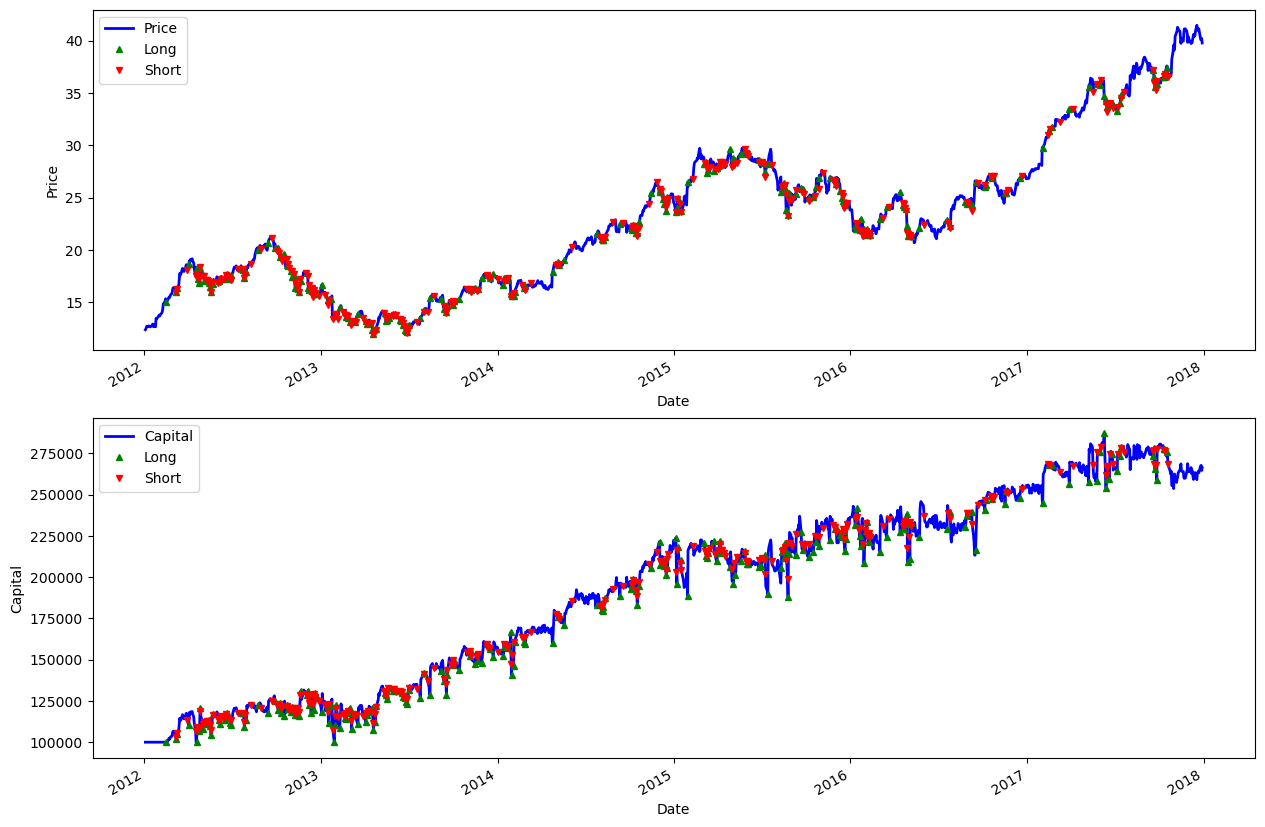

In [100]:
render(TrainingData)

In [101]:
TrainingData.query('Action == 0')

,Close,High,Low,Open,Volume,Position,Action,Holdings,Cash,Money,Returns
Date,,,,,,,,,,,
2012-01-03,12.375389,12.413608,12.308281,12.320319,302220800,0,0,0.000000,100000.000000,100000.000000,0.000000
2012-01-04,12.441895,12.479212,12.316706,12.338374,260022000,0,0,0.000000,100000.000000,100000.000000,0.000000
2012-01-05,12.580027,12.595675,12.418724,12.487339,271269600,0,0,0.000000,100000.000000,100000.000000,0.000000
2012-01-06,12.711534,12.722066,12.615836,12.632388,318292800,0,0,0.000000,100000.000000,100000.000000,0.000000
2012-01-09,12.691375,12.872538,12.679939,12.804828,394024400,0,0,0.000000,100000.000000,100000.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,41.126076,41.222424,41.006231,41.048528,65397600,-1,0,-273570.655853,536839.721153,263269.065300,-0.003270
2017-12-26,40.082706,40.294198,39.873560,40.136754,132742000,-1,0,-269355.787354,536839.721153,267483.933800,0.016010
2017-12-27,40.089764,40.132061,39.880620,39.972267,85992800,-1,0,-269122.583324,536839.721153,267717.137829,0.000872


In [102]:
TestingData, QValues0, QValues1 = testing(TrainingData, dataTest, main_network)
TestingData.index = pd.to_datetime(TestingData.index)

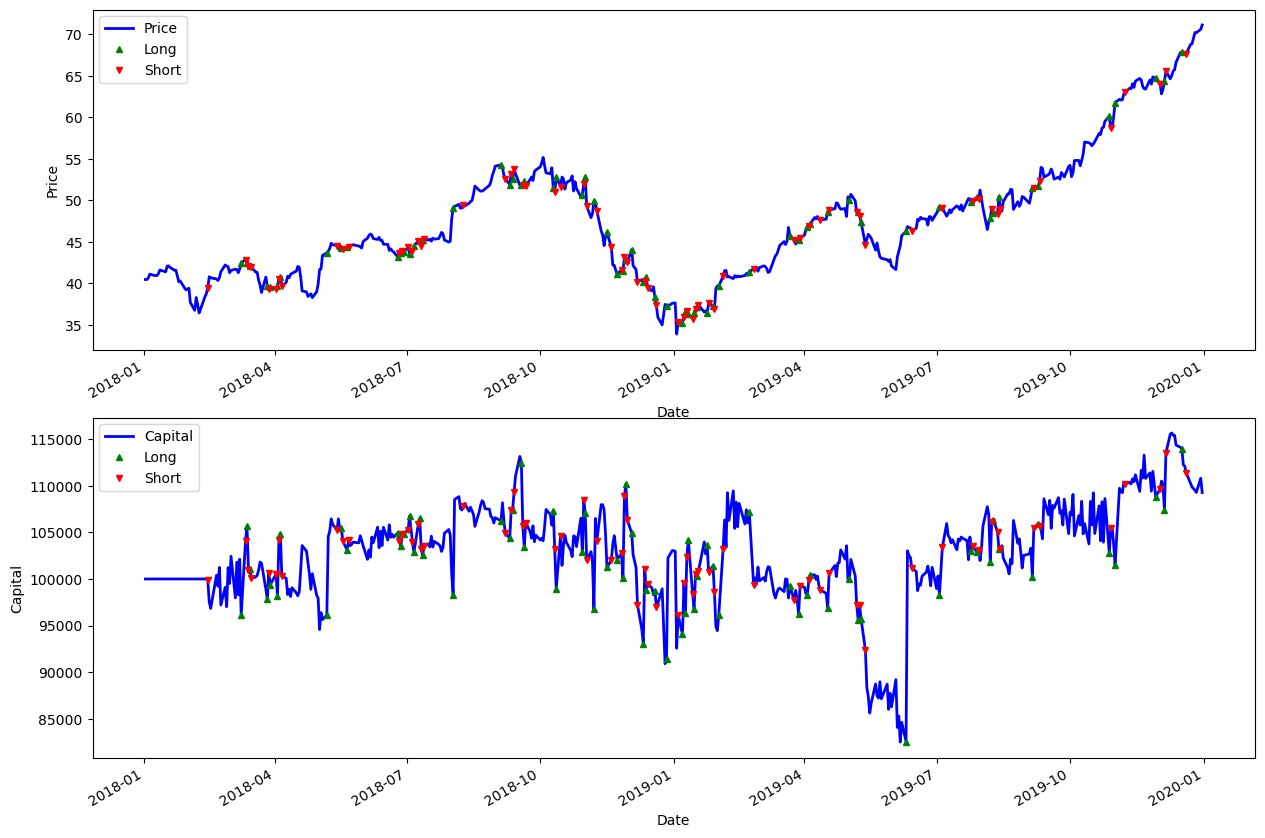

In [103]:
render(TestingData)

In [104]:
def plotEntireTrading(trainingEnv, testingEnv):
    """
    GOAL: Plot the entire trading activity, with both the training
            and testing phases rendered on the same graph for
            comparison purposes.
    
    INPUTS: - trainingEnv: Trading environment for training.
            - testingEnv: Trading environment for testing.
    
    OUTPUTS: /
    """

    # Artificial trick to assert the continuity of the Money curve
    ratio = trainingEnv['Money'][-1]/testingEnv['Money'][0]
    testingEnv['Money'] = ratio * testingEnv['Money']

    # Concatenation of the training and testing trading dataframes
    dataframes = [trainingEnv, testingEnv]
    data = pd.concat(dataframes)

    # Set the Matplotlib figure and subplots
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(211, ylabel='Price', xlabel='Time')
    ax2 = fig.add_subplot(212, ylabel='Capital', xlabel='Time', sharex=ax1)

    # Plot the first graph -> Evolution of the stock market price
    trainingEnv['Close'].plot(ax=ax1, color='blue', lw=2)
    testingEnv['Close'].plot(ax=ax1, color='blue', lw=2, label='_nolegend_') 
    ax1.plot(data.loc[data['Action'] == 1.0].index, 
                data['Close'][data['Action'] == 1.0],
                '^', markersize=5, color='green')   
    ax1.plot(data.loc[data['Action'] == -1.0].index, 
                data['Close'][data['Action'] == -1.0],
                'v', markersize=5, color='red')
    
    # Plot the second graph -> Evolution of the trading capital
    trainingEnv['Money'].plot(ax=ax2, color='blue', lw=2)
    testingEnv['Money'].plot(ax=ax2, color='blue', lw=2, label='_nolegend_') 
    ax2.plot(data.loc[data['Action'] == 1.0].index, 
                data['Money'][data['Action'] == 1.0],
                '^', markersize=5, color='green')   
    ax2.plot(data.loc[data['Action'] == -1.0].index, 
                data['Money'][data['Action'] == -1.0],
                'v', markersize=5, color='red')

    # Plot the vertical line seperating the training and testing datasets
    ax1.axvline(pd.Timestamp(splittingDate), color='black', linewidth=2.0)
    ax2.axvline(pd.Timestamp(splittingDate), color='black', linewidth=2.0)
    
    # Generation of the two legends and plotting
    ax1.legend(["Price", "Long",  "Short", "Train/Test separation"])
    ax2.legend(["Capital", "Long", "Short", "Train/Test separation"])
    # plt.savefig(''.join(['Figures/', str(trainingEnv.marketSymbol), '_TrainingTestingRendering', '.png'])) 
    plt.show()

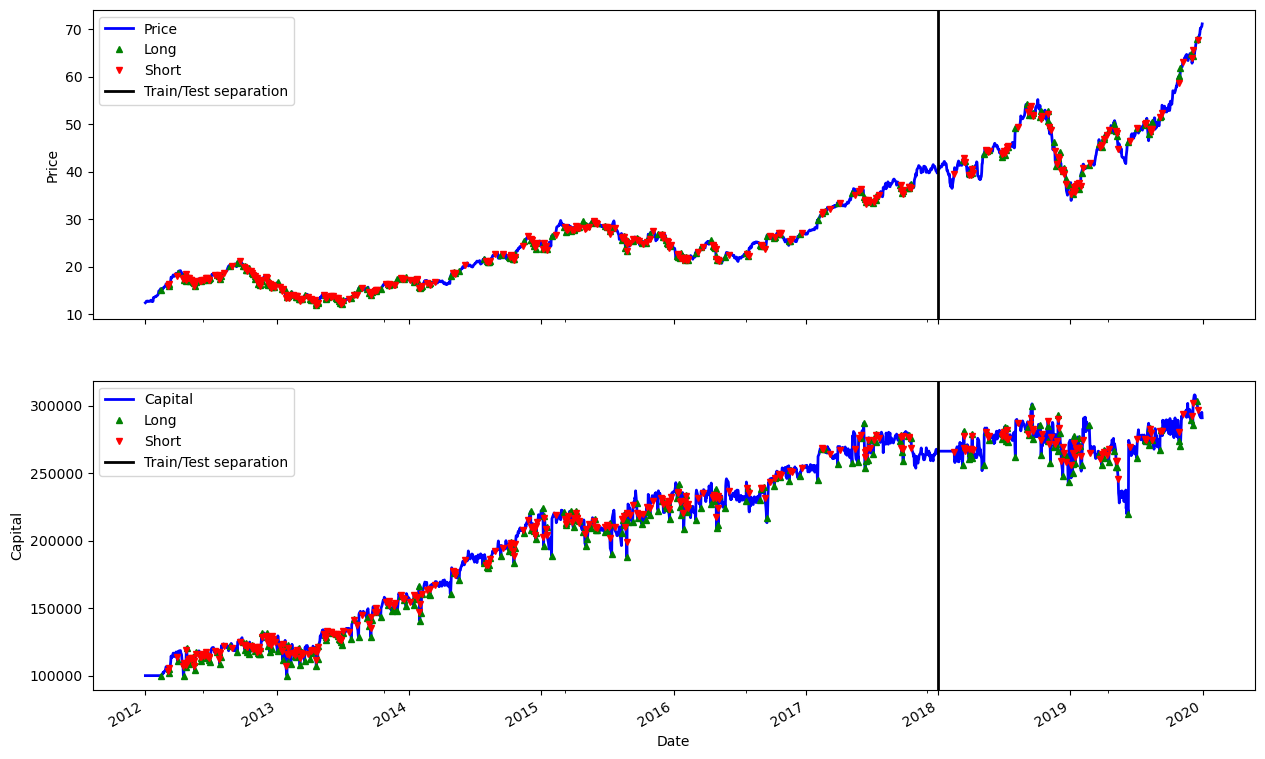

In [105]:
plotEntireTrading(TrainingData, TestingData)

In [106]:
from tradingPerformance2 import displayPerformance

In [107]:
print("Sharpe Ratio TDQN :", sharpe_ratio_annualized(TestingData['Returns']))
print("Sharpe Ratio B&H :", sharpe_ratio_annualized(TestingData['Close'].iloc[stateLength:].pct_change()))

Sharpe Ratio TDQN : 0.3099161696351556
Sharpe Ratio B&H : 1.2821791018654838


In [108]:
print("Sharpe Ratio B&H :", sharpe_ratio_annualized(dataTest['Close'].iloc[stateLength:].pct_change()))

Sharpe Ratio B&H : 1.2821791018654838


In [109]:
displayPerformance(TestingData, "TDQN")

╒═══════════════════════════╤══════════╕
│   Performance Indicator   │   TDQN   │
╞═══════════════════════════╪══════════╡
│    Profit & Loss (P&L)    │  24728   │
├───────────────────────────┼──────────┤
│     Annualized Return     │  12.36%  │
├───────────────────────────┼──────────┤
│   Annualized Volatility   │  42.35%  │
├───────────────────────────┼──────────┤
│       Sharpe Ratio        │  0.310   │
├───────────────────────────┼──────────┤
│       Sortino Ratio       │  0.546   │
├───────────────────────────┼──────────┤
│     Maximum Drawdown      │  27.12%  │
├───────────────────────────┼──────────┤
│ Maximum Drawdown Duration │ 180 days │
├───────────────────────────┼──────────┤
│       Profitability       │  46.72%  │
├───────────────────────────┼──────────┤
│ Ratio Average Profit/Loss │  1.197   │
├───────────────────────────┼──────────┤
│         Skewness          │  2.114   │
╘═══════════════════════════╧══════════╛


In [110]:
displayPerformance(TrainingData, "TDQN")

╒═══════════════════════════╤══════════╕
│   Performance Indicator   │   TDQN   │
╞═══════════════════════════╪══════════╡
│    Profit & Loss (P&L)    │  166260  │
├───────────────────────────┼──────────┤
│     Annualized Return     │  16.06%  │
├───────────────────────────┼──────────┤
│   Annualized Volatility   │  39.77%  │
├───────────────────────────┼──────────┤
│       Sharpe Ratio        │  0.605   │
├───────────────────────────┼──────────┤
│       Sortino Ratio       │  1.048   │
├───────────────────────────┼──────────┤
│     Maximum Drawdown      │  16.16%  │
├───────────────────────────┼──────────┤
│ Maximum Drawdown Duration │ 161 days │
├───────────────────────────┼──────────┤
│       Profitability       │  44.51%  │
├───────────────────────────┼──────────┤
│ Ratio Average Profit/Loss │  1.437   │
├───────────────────────────┼──────────┤
│         Skewness          │  1.632   │
╘═══════════════════════════╧══════════╛


In [111]:
TrainingData[50:100]

,Close,High,Low,Open,Volume,Position,Action,Holdings,Cash,Money,Returns
Date,,,,,,,,,,,
2012-03-15,17.621605,18.056457,17.410649,18.044420,1159718000,1,0,113430.270866,7.866674,113438.137541,-0.008820
2012-03-16,17.621901,17.731140,17.394092,17.596321,825487600,1,0,113203.089188,7.866674,113210.955862,-0.002003
2012-03-19,18.089258,18.109420,17.726631,18.007103,901236000,1,0,115970.234282,7.866674,115978.100956,0.024442
2012-03-20,18.235518,18.263804,17.799762,18.041413,816662000,1,0,116670.840977,7.866674,116678.707651,0.006041
2012-03-21,18.131397,18.346567,18.098596,18.138620,644042000,1,0,115768.971424,7.866674,115776.838098,-0.007730
2012-03-22,18.036301,18.191584,17.921643,17.989354,623870800,1,0,114927.307800,7.866674,114935.174475,-0.007270
2012-03-23,17.937292,18.110330,17.887637,18.070908,430488800,1,0,114081.177750,7.866674,114089.044424,-0.007362
2012-03-26,18.266216,18.271334,17.913521,18.049843,595742000,1,0,115953.940933,7.866674,115961.807608,0.016415
2012-03-27,18.491919,18.546087,18.238530,18.242142,607129600,1,0,117164.796021,7.866674,117172.662695,0.010442
